In [63]:

import numpy as np
from PIL import Image
import cv2
import glob
from scipy import interpolate
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt
import os
from pathlib import Path

from ripser import ripser 
from persim import plot_diagrams
from sklearn.decomposition import PCA

#topological data analysis
from persim import plot_diagrams
from dreimac import CircularCoords 
from dreimac import CircleMapUtils as CMU

#plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

In [2]:

# Folder path containing the images
folder_path = '/Users/acrv/Documents/GitHub/MSRI-UP2023/frames'  # Replace with the actual folder path

# Create an empty array to store all RGB values
rgb_array = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Get the full file path
        file_path = os.path.join(folder_path, filename)

        # Read the image using OpenCV
        image = cv2.imread(file_path)

        # Convert the image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get the dimensions of the image
        height, width, _ = image.shape

        # Reshape the image array to a 2D array of shape (height * width, 3)
        reshaped_image = np.reshape(image, (height * width, 3))

        # Append the RGB values of the current image to the array
        rgb_array.append(reshaped_image)

# Convert the RGB values array to a NumPy array
rgb_array = np.array(rgb_array)


In [3]:

def loadVideo(filepath):
    vid = cv2.VideoCapture(filepath)
    _, image = vid.read()
    count = 0
    success = True
    n_row, n_col, _ = image.shape
    data = []
    while success:
        data.append(image.flatten()) 
        success,image = vid.read()
        count += 1
    vid.release() 
    data = np.array(data)
    print(count, " frames extracted")
    print("frame size = ", (n_row , n_col))
    print("data shape =", data.shape)
    return data , (n_row, n_col)


In [4]:

# Auxiliary video functions
def getSlidingWindowVideo(I, dim, Tau, dT):
    N = I.shape[0] #Number of frames
    P = I.shape[1] #Number of pixels (possibly after PCA)
    pix = np.arange(P)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    X = np.zeros((NWindows, dim*P))
    idx = np.arange(N)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))
        f = interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
        X[i, :] = f(pix, idxx).flatten()
    return X


In [5]:

data1 , shape = loadVideo('dots_quasi.wmv')
#n_row, n_col = shape


390  frames extracted
frame size =  (100, 200)
data shape = (390, 60000)


In [6]:
import cv2

# Path to your video file
video_path = 'dots_quasi.wmv'

# Open the video file
video = cv2.VideoCapture(video_path)

# Get the frames per second (FPS) from the video
fps = video.get(cv2.CAP_PROP_FPS)

# Print the FPS
print("FPS:", fps)

# Release the video capture object
video.release()


FPS: 30.0


In [35]:

wSize = 15
dim = 3
Tau = wSize/float(dim)

desiredSamples = 400
M = data1.shape[0] - wSize + 1
dT = M/float(desiredSamples)

X = getSlidingWindowVideo(data1, dim, Tau, dT)


/var/folders/2f/76h8xtxd6yn1mn8rfx554nth0000gn/T/ipykernel_9559/3493765057.py:13: DeprecationWarning:

`interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`


/var/folders/2f/76h8xtxd6yn1mn8rfx554nth0000gn/T/ipykernel_9559/3493765057.py:14: DeprecationWarning:

        `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.



In [32]:
X.shape

(398, 120000)

/Users/acrv/anaconda3/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?



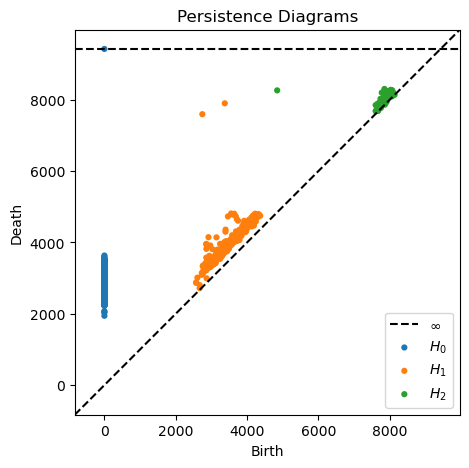

In [36]:

# Persistence Computation
rips_persistence = ripser(X, maxdim=2)
dgms = rips_persistence['dgms']
plt.figure(figsize = (5,5)) 
plot_diagrams(dgms, title='Persistence Diagrams')


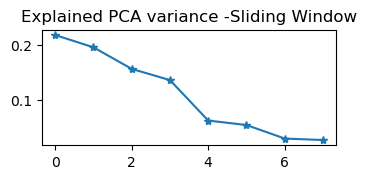

In [45]:
# PCA of the Sliding window point cloud
pca = PCA(n_components=8)

X_pca = pca.fit(X).transform(X)
plt.figure(figsize = (3.8,1.5))
plt.plot(pca.explained_variance_ratio_, '-*') ;
plt.title('Explained PCA variance -Sliding Window');

In [46]:
fig = go.Figure(data=[go.Scatter3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 2.5, color = 'brown')
)] , layout = go.Layout(scene = dict(aspectmode= 'data')))

fig.show()

In [41]:
X_pca.shape 

(398, 10)

In [49]:

# Get the circular coordinates at birth, and for the 2 cocycles with highest persistence
coho_classes = [0, 1]

circular_coords = []

n_lands = 200

cc = CircularCoords(X_pca, n_landmarks=n_lands)

for i in coho_classes:
    theta = cc.get_coordinates(perc=0, cocycle_idx=i)
    theta = CMU.to_sinebow(np.pi + CMU.center(theta))
    circular_coords.append(theta)


In [87]:
circular

array([[3.91646470e-05, 7.55400043e-01, 7.44560793e-01],
       [2.07154383e-02, 8.62990291e-01, 6.16294270e-01],
       [1.92783868e-01, 9.95241914e-01, 3.11974218e-01],
       ...,
       [4.47285007e-01, 9.56956901e-01, 9.57580920e-02],
       [6.43640719e-01, 8.42939219e-01, 1.34200621e-02],
       [7.80012997e-01, 7.18733715e-01, 1.25328755e-03]])

In [92]:
fig = go.Figure(data=[go.Scatter3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 2, color = theta)
)] , layout = go.Layout(scene = dict(aspectmode= 'data')))

fig.show()

In [56]:

fig = make_subplots(rows=1, cols=len(coho_classes), 
                    subplot_titles = tuple('Circ Coord '+str(i+1) for i in coho_classes),
                    specs = [[{'type': 'scatter3d'} for i in coho_classes]])

for i, coord in enumerate(circular_coords):
    fig.add_trace(
        go.Scatter3d(x=X_pca.T[0], y=X_pca.T[1], z=X_pca.T[2],   mode ='markers', 
        marker=dict(size = 2 , color = circular_coords[i])),  
        row=1, col=i+1)
    fig.update_scenes(xaxis=dict( ticks='', showticklabels=False), 
                      yaxis=dict( ticks='', showticklabels=False), 
                      zaxis=dict( ticks='', showticklabels=False), 
                      aspectmode='data', row=1, col=i+1)

fig.update_layout( showlegend=False )
fig.show()


In [57]:
def writeVideo(filename, frame_data, fps, resol ):
    n_row, n_col = resol
    out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (n_col, n_row))
    if frame_data.dtype !='uint8':
        frame_data -= np.amin(frame_data)
        frame_data *= 255/np.amax(frame_data)
        frame_data = np.uint8(frame_data)
    for frame in frame_data:
        out.write(frame.reshape((n_row, n_col,-1)))
    out.release()

def playVideo(filepath):
    cap = cv2.VideoCapture(filepath)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('frame', frame)
        if cv2.waitKey(24) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows() 

In [95]:
X_sorted = X[np.argsort(circular_coords[1])]

In [99]:
X

array([[125., 125., 125., ..., 125., 125., 125.],
       [125., 125., 125., ..., 125., 125., 125.],
       [125., 125., 125., ..., 125., 125., 125.],
       ...,
       [125., 125., 125., ..., 125., 125., 125.],
       [125., 125., 125., ..., 125., 125., 125.],
       [125., 125., 125., ..., 125., 125., 125.]])

In [100]:
X_sorted[:,0]

array([[125., 125., 125., ..., 125., 125., 125.],
       [125., 125., 125., ..., 125., 125., 125.],
       [125., 125., 125., ..., 125., 125., 125.],
       ...,
       [125., 125., 125., ..., 125., 125., 125.],
       [125., 125., 125., ..., 125., 125., 125.],
       [125., 125., 125., ..., 125., 125., 125.]])

In [68]:
import numpy as np
from scipy import interpolate

def reverseSlidingWindowVideo(X, dim, Tau, dT, original_shape):
    NWindows, dimP = X.shape
    N = original_shape[0]
    P = original_shape[1]
    pix = np.arange(P)
    I = np.zeros((N, P))

    idx = np.arange(N)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))

        f = interpolate.interp2d(pix, idxx, X[i, :].reshape(dim, P), kind='linear')
        I[idx[start:end+1], :] = f(pix, idx[start:end+1])

    return I


In [74]:
Y = reverseSlidingWindowVideo(X, dim, Tau, dT, (390, 60000))

/var/folders/2f/76h8xtxd6yn1mn8rfx554nth0000gn/T/ipykernel_9559/513802197.py:17: DeprecationWarning:

`interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`


/var/folders/2f/76h8xtxd6yn1mn8rfx554nth0000gn/T/ipykernel_9559/513802197.py:18: DeprecationWarning:

        `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

  

In [77]:
writeVideo('test.wmv', Y_sorted, 30, (100, 200))

In [78]:
playVideo('test.wmv')